# 6 Pair correlation and nearest neighbors

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import os

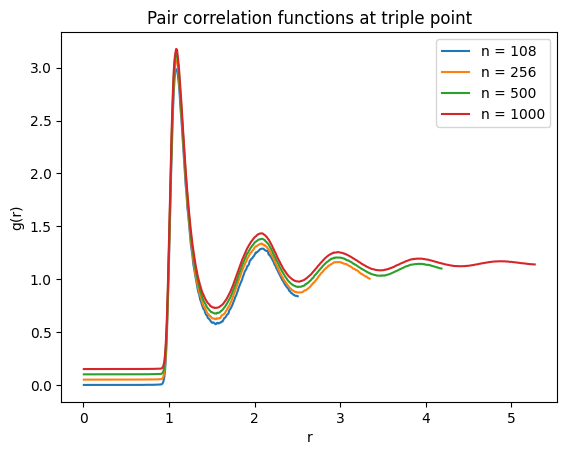

In [210]:
particleNumber = [108,256,500,1000]
offset = .05 # offset by which each correlation function is offset to see it better


for i, m in enumerate(particleNumber):
    r,g = np.loadtxt(f'n{m}/amclj.dat', unpack = True)
    plt.plot(r,g+offset*i, label = f"n = {m}")

plt.title("Pair correlation functions at triple point")
plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()
#plt.xlim([0,3.5])
plt.show()

Here, we have plotted the pair correlation functions $g(r)$ of liquid Argon at the triple point for different particle numbers $n$.
Note that I have offset each pcf by a small y-value so that we can see them better, but they are actually remarkably close to one another.

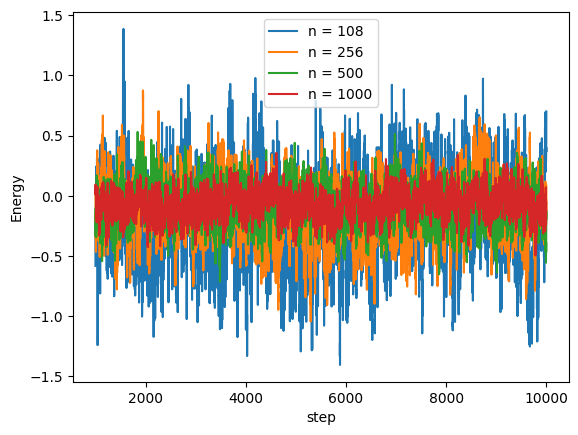

In [212]:
starting_step = 1000

for i, m in enumerate(particleNumber):
    step, acceptance, energy, pressure = np.loadtxt(f"n{m}/data.dat", unpack = True)
    plt.plot(step[starting_step:], pressure[starting_step:], label = f"n = {m}")

plt.legend()
plt.xlabel("step")
plt.ylabel("Energy")
plt.show()

Here we can see the Energies after equilibriation. The higher the $n$, the less they fluctuate.

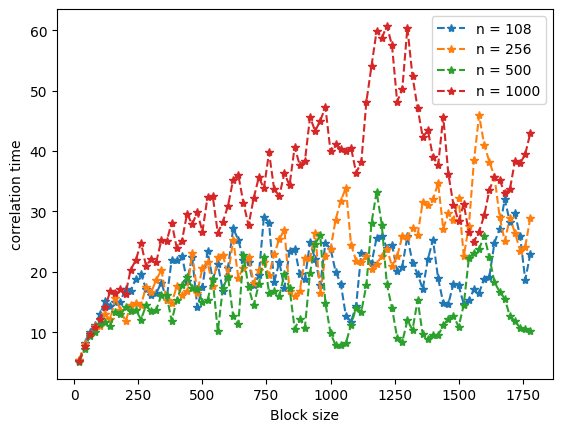

In [196]:
def calculate_correlation_time(variable):
    n = len(variable)

    m = np.arange(20,n//5,20)

    correlation_time = np.zeros(m.shape)
    var = np.var(variable)

    for j, mm in enumerate(m):
        
        # Trim the variable so you can do calculations
        length = n - n % mm
        variable_ = variable.copy()[:length]
        #print(len(variable)-mm)

        Am = np.reshape(variable_, (-1,mm))
        Am_average = Am.mean(axis=1)
        correlation_time[j] = np.var(Am_average)*mm/var/2
    return m, correlation_time

plotOffset = 0


for i, m in enumerate(particleNumber):
    step, acceptance, energy, pressure = np.loadtxt(f"n{m}/data.dat", unpack = True)

    binSize, correlationTime = calculate_correlation_time(energy[starting_step:])

    plt.plot(binSize, correlationTime + plotOffset * i , '--*', label = f"n = {m}")


plt.xlabel('Block size')
plt.ylabel('correlation time')
plt.legend()
plt.show()

In [215]:
# Calculate the stderrors:

starting_step = 2000
minimalAcceptedBlockSize = 400

energyDeviations = []
pressureDeviations = []

energies = []
pressures = []


print(f"{'_'*80}")
print(f"{'Energy':^80}")
print(f"{'_'*80}")

print(f"{'n':<10}{f'Mean':<30}{f'correlated stdev':<20}{f'relative Error':}\n")


for i, m in enumerate(particleNumber):


    step, acceptance, energy, pressure = np.loadtxt(f"n{m}/data.dat", unpack = True)

    stepTruncated = step[starting_step:]

    energyTruncated = energy[starting_step:]

    pressureTruncated = pressure[starting_step:]


    ### Energy

    binSize, correlationTime = calculate_correlation_time(energyTruncated)

    averageEnergyCorrelationTime = np.mean(correlationTime[binSize >= minimalAcceptedBlockSize])

    energyMean = np.mean(energyTruncated)

    energyStdev = np.std(energyTruncated, ddof = 1)

    energyCorrStdev = energyStdev * np.sqrt(2 * averageEnergyCorrelationTime / minimalAcceptedBlockSize)

    energies.append(energyMean)

    energyDeviations.append(energyCorrStdev/abs(energyMean)*100)



    ### pressure

    binSize, correlationTime = calculate_correlation_time(pressureTruncated)

    averagePressureCorrelationTime = np.mean(correlationTime[binSize >= minimalAcceptedBlockSize])

    pressureMean = np.mean(pressureTruncated)

    pressureStdev = np.std(pressureTruncated, ddof= 1)

    pressureCorrStdev = pressureStdev * np.sqrt(2 * averagePressureCorrelationTime / minimalAcceptedBlockSize)

    pressures.append(pressureMean)

    pressureDeviations.append(pressureCorrStdev/abs(pressureMean)* 100)

    ###

    print(f"{m:<10}{energyMean:<30.2e}{energyCorrStdev:<20.2e}{energyCorrStdev / abs(energyMean) * 100 :>0.2f} %\n")
print(f"{'_'*80}")



________________________________________________________________________________
                                     Energy                                     
________________________________________________________________________________
n         Mean                          correlated stdev    relative Error

108       -6.10e+00                     2.48e-02            0.41 %

256       -6.09e+00                     1.56e-02            0.26 %

500       -6.09e+00                     9.08e-03            0.15 %

1000      -6.08e+00                     1.13e-02            0.19 %

________________________________________________________________________________


In [290]:
### Fit the energy with particleNumber

from scipy.optimize import curve_fit

def exponentialModel(particleNumber, scaling, tau, offset):
    return scaling * np.exp(particleNumber * tau) + offset

(scalingEnergy, tauEnergy, offsetEnergy), _ = curve_fit(exponentialModel, particleNumber, energies, p0 = [1,-0.001,-6.1])
(scalingPressure, tauPressure, offsetPressure), _ = curve_fit(exponentialModel, particleNumber, energies, p0 = [-0.03,-0.004,-0.05],bounds = ([-0.4,-0.4,-0.1],[0,-.0001,0]),  maxfev = 50000)

del _

particleNumberFit = np.linspace(100,1301,1200)

energiesFit = exponentialModel(particleNumberFit, scalingEnergy, tauEnergy, offsetEnergy)
pressuresFit = exponentialModel(particleNumberFit, scalingPressure, tauPressure, offsetPressure)

offsetEnergy

-6.083905870474781

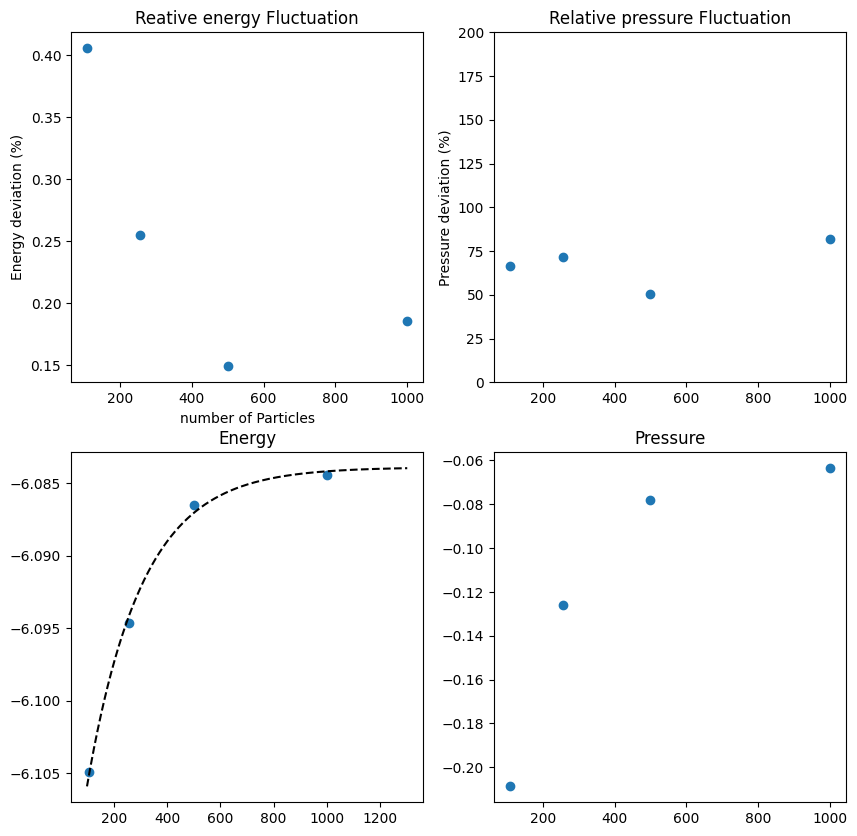

In [289]:


#### Plotting it:

fig, axes = plt.subplots(2, 2, figsize=(10,10))

[ax1, ax2], [ax3, ax4] = axes[:,:]

ax1.set_xlabel('number of Particles')
ax1.set_ylabel('Energy deviation (%)')
ax1.set_title("Reative energy Fluctuation")

ax1.scatter(particleNumber, energyDeviations)

ax2.scatter(particleNumber, pressureDeviations)
ax2.set_title("Relative pressure Fluctuation")
ax2.set_ylabel("Pressure deviation (%)")
ax2.set_ylim((0,200))

ax3.plot(particleNumberFit, energiesFit, '--k')
ax3.scatter(particleNumber, energies)
ax3.set_title("Energy")

#ax4.plot(particleNumberFit, pressuresFit, '--k')
ax4.scatter(particleNumber, pressures)
ax4.set_title("Pressure")
plt.show()

         Coordination number for n = 108:    12.5975
                                   R_min:     1.5450


         Coordination number for n = 256:    12.5413
                                   R_min:     1.5450


         Coordination number for n = 500:    12.6760
                                   R_min:     1.5550


        Coordination number for n = 1000:    12.3817
                                   R_min:     1.5350




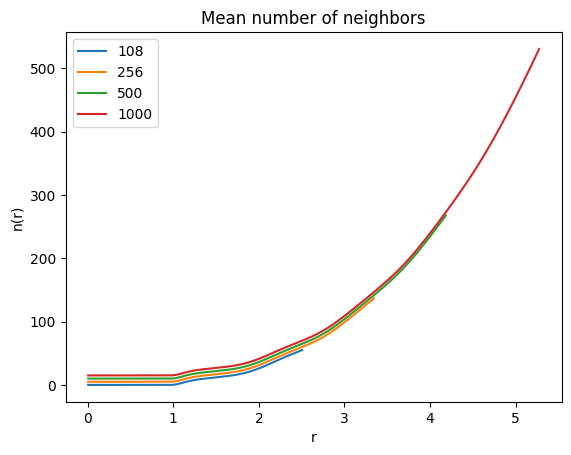

In [198]:
from scipy.signal import argrelmin

nOffset = 5 # offset for nice displaying

rho = 0.84

for i, m in enumerate(particleNumber):
    r,g = np.loadtxt(f'n{m}/amclj.dat', unpack = True)
    
    integrand = r**2 * g

    n = []
    coordination_number = []
    
    for rj in r:
        n.append(rho*4*np.pi*np.trapz(integrand[r<=rj], r[r<=rj]))

    index_min = argrelmin(g, order = 50)[0][0]
    r_min = r[index_min]
    
    n = np.array(n)


    print(f'{f"Coordination number for n = {m}":>40}: {n[index_min]:>10.4f}\n{f"R_min":>40}: {r_min:>10.4f}\n\n')


    plt.plot(r,n+i*nOffset,label = m)

plt.title('Mean number of neighbors')
plt.xlabel("r")
plt.ylabel("n(r)")
#plt.xlim([1,3.5])
#plt.ylim([0,5])
plt.legend()
plt.show()        

In [199]:
def extractPositionFromTraj(fileName, particleNumber, steps, saveEvery):
    data = np.loadtxt(fileName, delimiter="@", dtype=str)
    # Total number of rows
    numberOfRows = data.shape[0]

    skipRows = 2

    # Select every (particleNumber + skipRows) block, keeping only the first particleNumber rows of each
    cleanStringList = []
    i = skipRows
    while i < numberOfRows:
        cleanStringList.append(data[i:i+particleNumber])  # take particleNumber rows
        i += particleNumber + skipRows           # skip next 'skipRews' rows

    del data

    # Stack the result into one array
    positionArray = np.vstack(cleanStringList).flatten()


    finalArray = np.array([line.split()[1:] for line in positionArray], dtype=float)

    return finalArray.reshape(steps,particleNumber,3)[::saveEvery]

4.4933234323311035


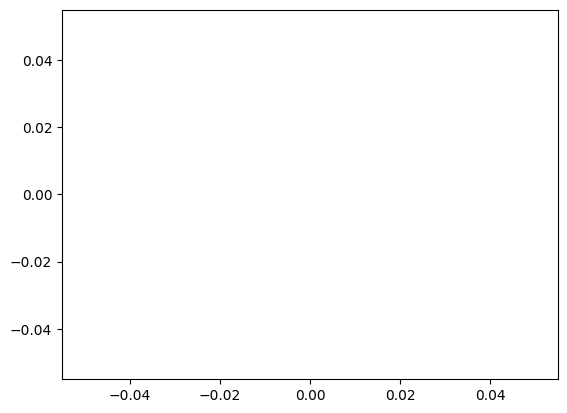

In [200]:
showEvery = 100

particleNumber = 108

density = 0.84

volume = density * particleNumber
boxLength = volume**(1/3)

print(boxLength)

#boxLength = 3.904483

boxLength = 5.047173

positions = extractPositionFromTraj(f"n{particleNumber}/traj.xyz", particleNumber, 10000, 1)

steps = 10000

starting_step = 1000

for step in range(starting_step,steps):
    centralParticlePosition = positions[step, 0, :]
    
    positions[step,:,:] -= centralParticlePosition

    positions[step,:,:] -= np.round(positions[step,:,:] / boxLength) * boxLength


zThickness = 1.6
zMask = np.all(positions[:, :, -1] < zThickness, axis=1)
filteredPositions = positions[zMask]

plt.plot(filteredPositions[starting_step:,:,0], filteredPositions[starting_step:,:,1], 'o', markersize = 0.01, color = 'blue')
plt.show()

# 7 The Structure Factor

In [201]:
r, g = np.loadtxt('n1000/amclj.dat', unpack = True)
rho = 0.84

We will calculate the structure factor $S(k)$

$$
S(k) = 1 + \frac{4\pi\rho}{k} \times \int_0^\infty {\rm{d}}r\ r \sin(kr) [g(r) - 1]
$$

for our case with `particleNumber = 1000`. Technically, the integral goes to $\infty$, but the maximum r is at `max(r)`

In [202]:
max(r)

5.275

We will just integrate using the trapezoidal rule and we define $S(k)$ as a function of $k$.

In [203]:
def structureFactor(k):
    kr = np.outer(k, r)               # shape (len(k), len(r))
    integrand = r * np.sin(kr) * (g - 1)    # broadcasts over r
    integrals = np.trapz(integrand, x=r, axis=1)  # integrate over r for each k
    return 1 + 4 * np.pi * rho * integrals / (k + 1e-12)

structureFactor(1)

array([-0.02799143])

Text(0.5, 1.0, 'Structure Factor')

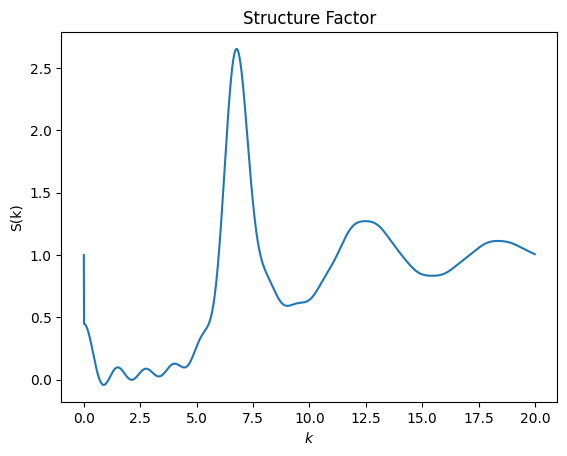

In [204]:
k = np.arange(0,20,.01)

plt.plot(k, structureFactor(k))
plt.xlabel("$k$")
plt.ylabel("S(k)")
plt.title("Structure Factor")

Now we will try to recreate the __Pair correlation function__ using the integral

$$
g(r) = 1 + \frac{1}{2\pi^2\rho r}\times\int _0 ^\infty {\rm d}k\ k \sin(kr)[S(k) - 1]
$$

Because we cannot calculate the integral to infinity, we will use a cutoff (The standard cutoff is $20/\sigma$): 
```cutoff```

To discretize $k$, we will use a `kStep`:

`np.arange(0, cutoff, kStep)`

In [205]:
cutoff = 50 # sigma = 1

kStep = 0.01

k = np.linspace(0, cutoff, 528)

def gReconstructed(r):
    # kr: shape (len(r), len(k)) = outer product of r and k
    kr = np.outer(r, k)
    
    # integrand: shape (len(r), len(k))
    integrand = k * np.sin(kr) * (structureFactor(k) - 1)  # S_k is shape (len(k),)
    
    # integrate along k-axis (axis=1) for each r
    integrals = np.trapz(integrand, x=k, axis=1)

    # final g(r)
    denominator = 2 * np.pi**2 * rho * r + 1e-12
    result = 1 + integrals / denominator
    return result

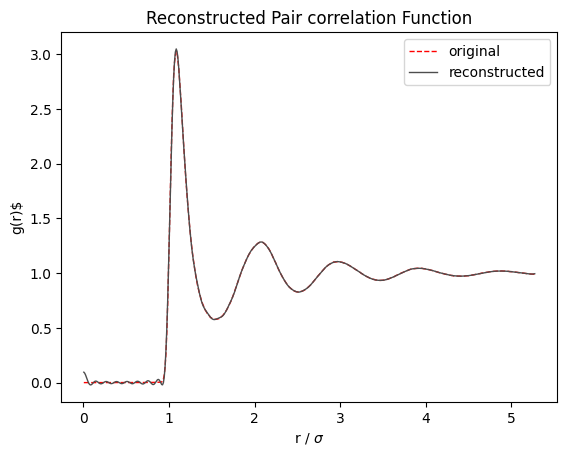

In [206]:
plt.plot(r,g, '--r', linewidth='1', label = "original")

plt.plot(r, gReconstructed(r), linewidth = '1',color = '0.3', label = "reconstructed")
plt.xlabel(f"r / $\sigma$")
plt.ylabel(f"g(r)$")
plt.legend()
plt.title("Reconstructed Pair correlation Function")
plt.show()